In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [4]:
%pip install mlflow
%pip install dagshub

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (roc_auc_score, precision_recall_curve, auc, 
                            average_precision_score, precision_score, 
                            recall_score, f1_score, confusion_matrix,
                            classification_report, roc_curve)
import xgboost as xgb
import time
import warnings
import gc
import mlflow
import mlflow.sklearn
import mlflow.xgboost
import os
import dagshub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE

# mlflow initialization

In [29]:
# Ignore warnings
warnings.filterwarnings('ignore')

# Start timer
start_time = time.time()

# Initialize MLflow tracking
try:
    # Initialize Dagshub
    dagshub.init(repo_owner='konstantine25b', repo_name='IEEE-CIS-Fraud-Detection', mlflow=True)
    print("DagsHub initialized successfully.")
    mlflow.set_experiment("IEEE-CIS Fraud Detection_XGBoost_Complete")
    print(f"MLflow experiment set to: {mlflow.get_experiment_by_name('IEEE-CIS Fraud Detection_XGBoost_Complete').name}")
    mlflow_active = True
except Exception as e:
    print(f"Could not initialize DagsHub or set MLflow experiment: {e}")
    print("Proceeding without MLflow tracking.")
    mlflow_active = False

Initialized MLflow to track repo "konstantine25b/IEEE-CIS-Fraud-Detection"

Repository konstantine25b/IEEE-CIS-Fraud-Detection initialized!

DagsHub initialized successfully.
MLflow experiment set to: IEEE-CIS Fraud Detection_XGBoost_Complete


In [30]:
# Start MLflow run
run_name = f"xgboost_models_{time.strftime('%Y%m%d_%H%M%S')}"
if mlflow_active:
    try:
        mlflow.start_run(run_name=run_name)
        print(f"MLflow run started with name: {run_name}")
    except Exception as e:
        print(f"Could not start MLflow run: {e}")
        mlflow_active = False

MLflow run started with name: xgboost_models_20250424_092203


# Load Data

In [31]:
print("\n--- Loading Original Data from Kaggle ---")
try:
    identity_df = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
    transaction_df = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
    
    print(f"Loaded train identity data shape: {identity_df.shape}")
    print(f"Loaded train transaction data shape: {transaction_df.shape}")
except FileNotFoundError:
    print("Error: One or both of the CSV files were not found. Please make sure the file paths are correct.")
    exit()


--- Loading Original Data from Kaggle ---
Loaded train identity data shape: (144233, 41)
Loaded train transaction data shape: (590540, 394)


# Pre-Processing

### drop columns with high null percentage

In [32]:

class HighNullDropper(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold
        self.columns_to_drop = None
    
    def fit(self, X, y=None):
        # Calculate null percentage for each column
        null_percentage = X.isnull().mean() * 100
        
        # Identify columns to drop
        self.columns_to_drop = null_percentage[null_percentage >= self.threshold].index.tolist()
        print(f"Identified {len(self.columns_to_drop)} columns with ≥{self.threshold}% nulls")
        
        return self
    
    def transform(self, X):
        if self.columns_to_drop:
            X_transformed = X.drop(columns=self.columns_to_drop)
            print(f"Dropped {len(self.columns_to_drop)} high-null columns. New shape: {X_transformed.shape}")
            return X_transformed
        return X


### woe

In [33]:
class WoEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, smoothing=0.5):
        self.smoothing = smoothing
        self.woe_maps = {}
        self.default_values = {}
    
    def fit(self, X, y):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        for col in X.columns:
            # Calculate WoE for each category
            woe_map = {}
            total_pos = y.sum()
            total_neg = len(y) - total_pos
            
            # Group by category and calculate counts
            grouped = pd.DataFrame({'target': y, 'feature': X[col]}).groupby('feature')
            counts = grouped.size()
            pos_counts = grouped['target'].sum()
            
            # Calculate WoE for each category
            for category, count in counts.items():
                if pd.isna(category):
                    continue
                
                pos = pos_counts.get(category, 0)
                neg = count - pos
                
                # Apply smoothing
                pos_rate = (pos + self.smoothing) / (total_pos + self.smoothing * len(counts))
                neg_rate = (neg + self.smoothing) / (total_neg + self.smoothing * len(counts))
                
                # Calculate WoE
                if neg_rate > 0 and pos_rate > 0:
                    woe = np.log(pos_rate / neg_rate)
                else:
                    woe = 0
                
                woe_map[category] = woe
            
            # Store WoE mapping for this column
            self.woe_maps[col] = woe_map
            
            # Calculate default value (weighted average)
            if woe_map:
                self.default_values[col] = sum(woe_map.values()) / len(woe_map)
            else:
                self.default_values[col] = 0
        
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        X_woe = X.copy()
        
        for col in X.columns:
            if col in self.woe_maps:
                # Replace each category with its WoE value
                woe_map = self.woe_maps[col]
                default_value = self.default_values[col]
                
                # Apply WoE mapping with default for unseen categories
                X_woe[col] = X_woe[col].map(lambda x: woe_map.get(x, default_value))
        
        return X_woe


### Custom transformer to identify and flag transactions with identity data

In [35]:
class IdentityFlagTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.transactions_with_identity = None
    
    def fit(self, X, identity_df, y=None):
        # Get TransactionIDs with identity information
        self.transactions_with_identity = set(identity_df['TransactionID'].unique())
        return self
    
    def transform(self, X):
        # Add identity flag
        X_copy = X.copy()
        X_copy['has_identity'] = X_copy['TransactionID'].isin(self.transactions_with_identity).astype(int)
        print(f"Added has_identity flag. Transactions with identity: {X_copy['has_identity'].sum()}")
        return X_copy

# Custom transformer to split data based on identity presence
class IdentitySplitter(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.with_identity_indices = None
        self.without_identity_indices = None
    
    def fit(self, X, y=None):
        if 'has_identity' not in X.columns:
            raise ValueError("has_identity column not found in the data")
        
        # Store indices for transactions with and without identity
        self.with_identity_indices = X[X['has_identity'] == 1].index
        self.without_identity_indices = X[X['has_identity'] == 0].index
        
        print(f"Identified {len(self.with_identity_indices)} transactions with identity")
        print(f"Identified {len(self.without_identity_indices)} transactions without identity")
        
        return self
    
    def transform(self, X):
        # Return the original data (splitting happens in get_with_identity and get_without_identity)
        return X
    
    def get_with_identity(self, X):
        return X.loc[self.with_identity_indices]
    
    def get_without_identity(self, X):
        return X.loc[self.without_identity_indices]

In [36]:

class IdentityMerger(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.identity_df = None
    
    def fit(self, X, identity_df, y=None):
        self.identity_df = identity_df
        return self
    
    def transform(self, X):
        if self.identity_df is None:
            raise ValueError("IdentityMerger not fitted. Call fit before transform.")
        
        # Merge transaction data with identity data
        merged = pd.merge(X, self.identity_df, on='TransactionID', how='left')
        print(f"Merged identity data. New shape: {merged.shape}")
        return merged
    
    def fit_transform(self, X, identity_df, y=None):
        return self.fit(X, identity_df).transform(X)

# Correlation

In [37]:
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.columns_to_drop = None
    
    def fit(self, X, y=None):
        # Calculate correlation matrix
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        corr_matrix = X.corr().abs()
        
        # Create a mask for the upper triangle
        upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        
        # Find features with correlation greater than threshold
        self.columns_to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        
        print(f"Identified {len(self.columns_to_drop)} highly correlated features to drop (threshold: {self.threshold})")
        
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
            
        if self.columns_to_drop:
            X_transformed = X.drop(columns=self.columns_to_drop)
            print(f"Dropped {len(self.columns_to_drop)} highly correlated features. New shape: {X_transformed.shape}")
            return X_transformed
        return X


# RFE

In [38]:
class XGBoostRFE(BaseEstimator, TransformerMixin):
    def __init__(self, n_features_to_select=None, step=1, verbose=0):
        self.n_features_to_select = n_features_to_select
        self.step = step
        self.verbose = verbose
        self.selected_features = None
        self.feature_names = None
        
    def fit(self, X, y):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        
        # Store feature names
        self.feature_names = X.columns.tolist()
        
        # Create a basic XGBoost model for feature selection
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42,
            tree_method='hist',
            verbosity=0
        )
        
        # Determine number of features to select if not specified
        if self.n_features_to_select is None:
            self.n_features_to_select = X.shape[1] // 2  # Default to half the features
        
        # Create RFE selector
        rfe = RFE(
            estimator=model,
            n_features_to_select=self.n_features_to_select,
            step=self.step,
            verbose=self.verbose
        )
        
        # Fit RFE
        rfe.fit(X, y)
        
        # Get selected feature indices
        self.selected_features = [i for i, selected in enumerate(rfe.support_) if selected]
        
        selected_names = [self.feature_names[i] for i in self.selected_features]
        print(f"RFE selected {len(selected_names)} features out of {len(self.feature_names)}")
        
        if self.verbose > 0:
            print("Top 20 selected features:")
            for i, feature in enumerate(selected_names[:20]):
                print(f"  {i+1}. {feature}")
        
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
            
        if self.feature_names is None:
            raise ValueError("This XGBoostRFE instance is not fitted yet. Call 'fit' before using 'transform'.")
        
        # Ensure X has the same columns as during fit
        if list(X.columns) != self.feature_names:
            raise ValueError("The feature names of X do not match those that were learned")
        
        # Select only the features identified by RFE
        X_selected = X.iloc[:, self.selected_features]
        
        print(f"Transformed data shape after RFE: {X_selected.shape}")
        return X_selected

### Step 1: Preprocess identity data

In [39]:
print("\n--- Preprocessing Identity Data ---")
identity_preprocessing_pipeline = Pipeline([
    ('high_null_dropper', HighNullDropper(threshold=20))  # Drop columns with ≥20% nulls
])

identity_preprocessed = identity_preprocessing_pipeline.fit_transform(identity_df)

if mlflow_active:
    mlflow.sklearn.log_model(identity_preprocessing_pipeline, "identity_preprocessing_pipeline")
    mlflow.log_param("identity_original_shape", str(identity_df.shape))
    mlflow.log_param("identity_preprocessed_shape", str(identity_preprocessed.shape))


2025/04/24 09:22:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!



--- Preprocessing Identity Data ---
Identified 19 columns with ≥20% nulls
Dropped 19 high-null columns. New shape: (144233, 22)


2025/04/24 09:22:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Step 2: Preprocess transaction data

In [41]:


print("\n--- Preprocessing Transaction Data ---")
transaction_preprocessing_pipeline = Pipeline([
    ('high_null_dropper', HighNullDropper(threshold=60))  # Drop columns with ≥60% nulls
])

transaction_preprocessed = transaction_preprocessing_pipeline.fit_transform(transaction_df)

if mlflow_active:
    mlflow.sklearn.log_model(transaction_preprocessing_pipeline, "transaction_preprocessing_pipeline")
    mlflow.log_param("transaction_original_shape", str(transaction_df.shape))
    mlflow.log_param("transaction_preprocessed_shape", str(transaction_preprocessed.shape))



--- Preprocessing Transaction Data ---
Identified 168 columns with ≥60% nulls


2025/04/24 09:22:59 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Dropped 168 high-null columns. New shape: (590540, 226)


2025/04/24 09:23:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Step 3: Add identity flag to transaction data

In [42]:
print("\n--- Adding Identity Flag ---")
identity_flagger = IdentityFlagTransformer()
transaction_with_flag = identity_flagger.fit_transform(transaction_preprocessed, identity_preprocessed)

if mlflow_active:
    mlflow.sklearn.log_model(identity_flagger, "identity_flagger")


--- Adding Identity Flag ---
Added has_identity flag. Transactions with identity: 144233


2025/04/24 09:23:54 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/24 09:23:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Step 4: Split data based on identity presence

In [43]:
print("\n--- Splitting Data Based on Identity Presence ---")
identity_splitter = IdentitySplitter()
identity_splitter.fit(transaction_with_flag)

# Get transactions with and without identity
transaction_with_identity = identity_splitter.get_with_identity(transaction_with_flag)
transaction_without_identity = identity_splitter.get_without_identity(transaction_with_flag)

if mlflow_active:
    mlflow.sklearn.log_model(identity_splitter, "identity_splitter")
    mlflow.log_param("with_identity_shape", str(transaction_with_identity.shape))
    mlflow.log_param("without_identity_shape", str(transaction_without_identity.shape))



--- Splitting Data Based on Identity Presence ---
Identified 144233 transactions with identity
Identified 446307 transactions without identity


2025/04/24 09:24:05 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/24 09:24:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Step 5: Merge identity data with transactions that have identity

In [44]:
print("\n--- Merging Identity Data ---")
identity_merger = IdentityMerger()
merged_df = identity_merger.fit_transform(transaction_with_identity, identity_preprocessed)

if mlflow_active:
    mlflow.sklearn.log_model(identity_merger, "identity_merger")
    mlflow.log_param("merged_shape", str(merged_df.shape))


print("\n--- Preparing Target Variable ---")
y_with_identity = merged_df['isFraud']
y_without_identity = transaction_without_identity['isFraud']

print(f"Target variable for WITH identity shape: {y_with_identity.shape}")
print(f"Target variable for WITHOUT identity shape: {y_without_identity.shape}")



--- Merging Identity Data ---
Merged identity data. New shape: (144233, 248)


2025/04/24 09:24:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/24 09:24:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



--- Preparing Target Variable ---
Target variable for WITH identity shape: (144233,)
Target variable for WITHOUT identity shape: (446307,)


### Function to categorize columns by data type and cardinality

In [45]:

def categorize_columns(df, target_col=None):
    if target_col:
        df = df.drop(columns=[target_col], errors='ignore')
    
    # Identify numeric and categorical columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    # Add integer columns with few unique values to categorical
    for col in df.select_dtypes(include=['int64']).columns:
        if df[col].nunique() < 20 and col != 'TransactionID':  # Consider low-cardinality integers as categorical
            if col in numeric_cols:
                numeric_cols.remove(col)
            if col not in categorical_cols:
                categorical_cols.append(col)
    
    # Remove TransactionID and has_identity from features
    for col in ['TransactionID', 'has_identity']:
        if col in numeric_cols:
            numeric_cols.remove(col)
        if col in categorical_cols:
            categorical_cols.remove(col)
    
    # Split categorical columns by cardinality
    onehot_cols = []
    woe_cols = []
    
    for col in categorical_cols:
        if df[col].nunique() < 4:  # Use OneHotEncoding for low cardinality
            onehot_cols.append(col)
        else:  # Use WoE for higher cardinality
            woe_cols.append(col)
    
    print(f"Identified {len(numeric_cols)} numeric columns")
    print(f"Identified {len(onehot_cols)} categorical columns for OneHotEncoding")
    print(f"Identified {len(woe_cols)} categorical columns for WoE Encoding")
    
    return numeric_cols, onehot_cols, woe_cols


In [46]:
print("\n--- Categorizing Columns for WITH Identity Dataset ---")
with_identity_numeric, with_identity_onehot, with_identity_woe = categorize_columns(merged_df, 'isFraud')

# Categorize columns for without_identity dataset
print("\n--- Categorizing Columns for WITHOUT Identity Dataset ---")
without_identity_numeric, without_identity_onehot, without_identity_woe = categorize_columns(transaction_without_identity, 'isFraud')

if mlflow_active:
    mlflow.log_param("with_identity_numeric_count", len(with_identity_numeric))
    mlflow.log_param("with_identity_onehot_count", len(with_identity_onehot))
    mlflow.log_param("with_identity_woe_count", len(with_identity_woe))
    mlflow.log_param("without_identity_numeric_count", len(without_identity_numeric))
    mlflow.log_param("without_identity_onehot_count", len(without_identity_onehot))
    mlflow.log_param("without_identity_woe_count", len(without_identity_woe))



--- Categorizing Columns for WITH Identity Dataset ---
Identified 220 numeric columns
Identified 20 categorical columns for OneHotEncoding
Identified 5 categorical columns for WoE Encoding

--- Categorizing Columns for WITHOUT Identity Dataset ---
Identified 211 numeric columns
Identified 10 categorical columns for OneHotEncoding
Identified 3 categorical columns for WoE Encoding


# Create feature preprocessing pipeline

In [47]:
# Create feature preprocessing pipeline for with_identity dataset
print("\n--- Creating Feature Preprocessing Pipeline for WITH Identity Dataset ---")
with_identity_feature_pipeline = Pipeline([
    ('column_transformer', ColumnTransformer([
        ('numeric', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), with_identity_numeric),
        ('onehot', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), with_identity_onehot),
        ('woe', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', WoEEncoder())
        ]), with_identity_woe)
    ], remainder='drop')),
    ('correlation_filter', CorrelationFilter(threshold=0.8)),
    ('rfe', XGBoostRFE(n_features_to_select=100, step=5, verbose=1))
])

# Create feature preprocessing pipeline for without_identity dataset
print("\n--- Creating Feature Preprocessing Pipeline for WITHOUT Identity Dataset ---")
without_identity_feature_pipeline = Pipeline([
    ('column_transformer', ColumnTransformer([
        ('numeric', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), without_identity_numeric),
        ('onehot', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), without_identity_onehot),
        ('woe', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', WoEEncoder())
        ]), without_identity_woe)
    ], remainder='drop')),
    ('correlation_filter', CorrelationFilter(threshold=0.8)),
    ('rfe', XGBoostRFE(n_features_to_select=100, step=5, verbose=1))
])



--- Creating Feature Preprocessing Pipeline for WITH Identity Dataset ---

--- Creating Feature Preprocessing Pipeline for WITHOUT Identity Dataset ---


### Step 6: Prepare data for model training

In [48]:
print("\n--- Preparing Data for Model Training ---")

# For with_identity dataset
X_with_identity = merged_df.drop(columns=['isFraud', 'TransactionID', 'has_identity'], errors='ignore')

# For without_identity dataset
X_without_identity = transaction_without_identity.drop(columns=['isFraud', 'TransactionID', 'has_identity'], errors='ignore')

print(f"With identity features shape: {X_with_identity.shape}")
print(f"Without identity features shape: {X_without_identity.shape}")



--- Preparing Data for Model Training ---
With identity features shape: (144233, 245)
Without identity features shape: (446307, 224)


### Step 7: Split data into train and validation sets

In [49]:
X_with_identity_train, X_with_identity_val, y_with_identity_train, y_with_identity_val = train_test_split(
    X_with_identity, y_with_identity, test_size=0.2, random_state=42, stratify=y_with_identity
)

print(f"With identity - Training set: {X_with_identity_train.shape}, Validation set: {X_with_identity_val.shape}")

# For without_identity dataset
X_without_identity_train, X_without_identity_val, y_without_identity_train, y_without_identity_val = train_test_split(
    X_without_identity, y_without_identity, test_size=0.2, random_state=42, stratify=y_without_identity
)

print(f"Without identity - Training set: {X_without_identity_train.shape}, Validation set: {X_without_identity_val.shape}")


With identity - Training set: (115386, 245), Validation set: (28847, 245)
Without identity - Training set: (357045, 224), Validation set: (89262, 224)


In [51]:
if mlflow_active:
    mlflow.log_param("with_identity_train_shape", str(X_with_identity_train.shape))
    mlflow.log_param("with_identity_val_shape", str(X_with_identity_val.shape))
    mlflow.log_param("without_identity_train_shape", str(X_without_identity_train.shape))
    mlflow.log_param("without_identity_val_shape", str(X_without_identity_val.shape))


### Step 9: Fit feature preprocessing pipelines and transform data

In [52]:
print("\n--- Fitting and Transforming Data ---")

# With identity pipeline
print("Processing WITH identity data...")
with_identity_feature_pipeline.fit(X_with_identity_train, y_with_identity_train)
X_with_identity_train_processed = with_identity_feature_pipeline.transform(X_with_identity_train)
X_with_identity_val_processed = with_identity_feature_pipeline.transform(X_with_identity_val)

print(f"Processed WITH identity - Train: {X_with_identity_train_processed.shape}, Val: {X_with_identity_val_processed.shape}")



--- Fitting and Transforming Data ---
Processing WITH identity data...
Identified 107 highly correlated features to drop (threshold: 0.8)
Dropped 107 highly correlated features. New shape: (115386, 132)
Fitting estimator with 132 features.
Fitting estimator with 127 features.
Fitting estimator with 122 features.
Fitting estimator with 117 features.
Fitting estimator with 112 features.
Fitting estimator with 107 features.
Fitting estimator with 102 features.
RFE selected 100 features out of 132
Top 20 selected features:
  1. 0
  2. 1
  3. 2
  4. 3
  5. 4
  6. 5
  7. 6
  8. 7
  9. 8
  10. 10
  11. 12
  12. 16
  13. 22
  14. 23
  15. 24
  16. 25
  17. 26
  18. 27
  19. 28
  20. 31
Dropped 107 highly correlated features. New shape: (115386, 132)
Transformed data shape after RFE: (115386, 100)
Dropped 107 highly correlated features. New shape: (28847, 132)
Transformed data shape after RFE: (28847, 100)
Processed WITH identity - Train: (115386, 100), Val: (28847, 100)


In [54]:
# Without identity pipeline
print("Processing WITHOUT identity data...")
without_identity_feature_pipeline.fit(X_without_identity_train, y_without_identity_train)
X_without_identity_train_processed = without_identity_feature_pipeline.transform(X_without_identity_train)
X_without_identity_val_processed = without_identity_feature_pipeline.transform(X_without_identity_val)

print(f"Processed WITHOUT identity - Train: {X_without_identity_train_processed.shape}, Val: {X_without_identity_val_processed.shape}")


Processing WITHOUT identity data...
Identified 104 highly correlated features to drop (threshold: 0.8)
Dropped 104 highly correlated features. New shape: (357045, 132)
Fitting estimator with 132 features.
Fitting estimator with 127 features.
Fitting estimator with 122 features.
Fitting estimator with 117 features.
Fitting estimator with 112 features.
Fitting estimator with 107 features.
Fitting estimator with 102 features.
RFE selected 100 features out of 132
Top 20 selected features:
  1. 0
  2. 1
  3. 2
  4. 3
  5. 4
  6. 5
  7. 6
  8. 7
  9. 8
  10. 9
  11. 13
  12. 23
  13. 25
  14. 26
  15. 27
  16. 28
  17. 29
  18. 30
  19. 31
  20. 32
Dropped 104 highly correlated features. New shape: (357045, 132)
Transformed data shape after RFE: (357045, 100)
Dropped 104 highly correlated features. New shape: (89262, 132)
Transformed data shape after RFE: (89262, 100)
Processed WITHOUT identity - Train: (357045, 100), Val: (89262, 100)


In [56]:
# Extract and log the selected features from each pipeline
with_identity_rfe = with_identity_feature_pipeline.named_steps['rfe']
without_identity_rfe = without_identity_feature_pipeline.named_steps['rfe']

# Get the selected feature names for with_identity pipeline
with_identity_selected_features = []
if hasattr(with_identity_rfe, 'feature_names') and with_identity_rfe.feature_names is not None:
    with_identity_selected_features = [with_identity_rfe.feature_names[i] for i in with_identity_rfe.selected_features]
    print(f"WITH identity selected features: {len(with_identity_selected_features)}")
    if len(with_identity_selected_features) > 0:
        print(f"Top 10 WITH identity features: {with_identity_selected_features[:10]}")

# Get the selected feature names for without_identity pipeline
without_identity_selected_features = []
if hasattr(without_identity_rfe, 'feature_names') and without_identity_rfe.feature_names is not None:
    without_identity_selected_features = [without_identity_rfe.feature_names[i] for i in without_identity_rfe.selected_features]
    print(f"WITHOUT identity selected features: {len(without_identity_selected_features)}")
    if len(without_identity_selected_features) > 0:
        print(f"Top 10 WITHOUT identity features: {without_identity_selected_features[:10]}")

if mlflow_active:
    mlflow.log_param("with_identity_train_processed_shape", str(X_with_identity_train_processed.shape))
    mlflow.log_param("with_identity_val_processed_shape", str(X_with_identity_val_processed.shape))
    mlflow.log_param("without_identity_train_processed_shape", str(X_without_identity_train_processed.shape))
    mlflow.log_param("without_identity_val_processed_shape", str(X_without_identity_val_processed.shape))
    
    # Log the selected features
    if len(with_identity_selected_features) > 0:
        mlflow.log_param("with_identity_feature_count", len(with_identity_selected_features))
        # Log top features (up to 20)
        for i, feature in enumerate(with_identity_selected_features[:20]):
            mlflow.log_param(f"with_identity_top_feature_{i+1}", feature)
    
    if len(without_identity_selected_features) > 0:
        mlflow.log_param("without_identity_feature_count", len(without_identity_selected_features))
        # Log top features (up to 20)
        for i, feature in enumerate(without_identity_selected_features[:20]):
            mlflow.log_param(f"without_identity_top_feature_{i+1}", feature)
    
    # Save feature lists to files and log as artifacts
    if len(with_identity_selected_features) > 0:
        with open('with_identity_selected_features.txt', 'w') as f:
            for feature in with_identity_selected_features:
                f.write(f"{feature}\n")
        mlflow.log_artifact('with_identity_selected_features.txt')
    
    if len(without_identity_selected_features) > 0:
        with open('without_identity_selected_features.txt', 'w') as f:
            for feature in without_identity_selected_features:
                f.write(f"{feature}\n")
        mlflow.log_artifact('without_identity_selected_features.txt')
    
    # Log the feature pipelines to MLflow
    mlflow.sklearn.log_model(with_identity_feature_pipeline, "with_identity_feature_pipeline")
    print("With identity feature pipeline saved to MLflow")
    
    mlflow.sklearn.log_model(without_identity_feature_pipeline, "without_identity_feature_pipeline")
    print("Without identity feature pipeline saved to MLflow")



WITH identity selected features: 100
Top 10 WITH identity features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10]
WITHOUT identity selected features: 100
Top 10 WITHOUT identity features: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


2025/04/24 09:51:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/04/24 09:51:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/24 09:51:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


With identity feature pipeline saved to MLflow


2025/04/24 09:51:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Without identity feature pipeline saved to MLflow


### Step 9: Save processed datasets

In [58]:

def array_to_df(array, prefix, index=None):
    df = pd.DataFrame(
        array,
        columns=[f"{prefix}_feature_{i}" for i in range(array.shape[1])]
    )
    if index is not None:
        df.index = index
    return df

In [59]:
# Save with identity processed data
with_identity_train_df = array_to_df(X_with_identity_train_processed, "with_id", X_with_identity_train.index)
with_identity_train_df['isFraud'] = y_with_identity_train.values
with_identity_train_df.to_csv('with_identity_train.csv')

with_identity_val_df = array_to_df(X_with_identity_val_processed, "with_id", X_with_identity_val.index)
with_identity_val_df['isFraud'] = y_with_identity_val.values
with_identity_val_df.to_csv('with_identity_val.csv')


In [60]:
# Save without identity processed data
without_identity_train_df = array_to_df(X_without_identity_train_processed, "without_id", X_without_identity_train.index)
without_identity_train_df['isFraud'] = y_without_identity_train.values
without_identity_train_df.to_csv('without_identity_train.csv')

without_identity_val_df = array_to_df(X_without_identity_val_processed, "without_id", X_without_identity_val.index)
without_identity_val_df['isFraud'] = y_without_identity_val.values
without_identity_val_df.to_csv('without_identity_val.csv')
print("All processed datasets saved to CSV files")

All processed datasets saved to CSV files


In [61]:
if mlflow_active:
    # Log the CSV files as artifacts
    mlflow.log_artifact('with_identity_train.csv')
    mlflow.log_artifact('with_identity_val.csv')
    mlflow.log_artifact('without_identity_train.csv')
    mlflow.log_artifact('without_identity_val.csv')

In [62]:
print("\n--- Fraud Rate Analysis ---")
with_identity_fraud_rate = y_with_identity.mean() * 100
without_identity_fraud_rate = y_without_identity.mean() * 100

print(f"Fraud rate in transactions WITH identity: {with_identity_fraud_rate:.2f}%")
print(f"Fraud rate in transactions WITHOUT identity: {without_identity_fraud_rate:.2f}%")
print(f"Fraud rate difference: {abs(with_identity_fraud_rate - without_identity_fraud_rate):.2f}%")

if mlflow_active:
    mlflow.log_metric("with_identity_fraud_rate", with_identity_fraud_rate)
    mlflow.log_metric("without_identity_fraud_rate", without_identity_fraud_rate)
    mlflow.log_metric("fraud_rate_difference", abs(with_identity_fraud_rate - without_identity_fraud_rate))



--- Fraud Rate Analysis ---
Fraud rate in transactions WITH identity: 7.85%
Fraud rate in transactions WITHOUT identity: 2.09%
Fraud rate difference: 5.75%


### Step 10: Train XGBoost models

In [63]:
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 30,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'scale_pos_weight': 1.0,  # Will be adjusted based on class imbalance
    'random_state': 42
}

# Function to train and evaluate XGBoost model
def train_and_evaluate_xgb(X_train, y_train, X_val, y_val, params, model_name):
    print(f"\nTraining {model_name} model...")
    
    # Adjust scale_pos_weight based on class imbalance
    neg_pos_ratio = np.sum(y_train == 0) / np.sum(y_train == 1)
    params['scale_pos_weight'] = neg_pos_ratio
    print(f"Class imbalance ratio (negative/positive): {neg_pos_ratio:.2f}")
    print(f"Using scale_pos_weight: {params['scale_pos_weight']:.2f}")
    
    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    # Train model with early stopping
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=10000,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=100,
        verbose_eval=100
    )
    
    # Make predictions
    y_pred_train = model.predict(dtrain)
    y_pred_val = model.predict(dval)
    
    # Calculate metrics
    train_auc = roc_auc_score(y_train, y_pred_train)
    val_auc = roc_auc_score(y_val, y_pred_val)
    
    train_ap = average_precision_score(y_train, y_pred_train)
    val_ap = average_precision_score(y_val, y_pred_val)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Train AUC: {train_auc:.4f}")
    print(f"Validation AUC: {val_auc:.4f}")
    print(f"Train Average Precision: {train_ap:.4f}")
    print(f"Validation Average Precision: {val_ap:.4f}")
    
    # Log metrics to MLflow
    if mlflow_active:
        try:
            # Log parameters safely - convert all values to strings to avoid MLflow errors
            safe_params = {f"{model_name}_{k}": str(v) for k, v in params.items()}
            mlflow.log_params(safe_params)
            
            # Log metrics
            mlflow.log_metric(f"{model_name}_train_auc", train_auc)
            mlflow.log_metric(f"{model_name}_val_auc", val_auc)
            mlflow.log_metric(f"{model_name}_train_ap", train_ap)
            mlflow.log_metric(f"{model_name}_val_ap", val_ap)
            
            # Log feature importance
            fig, ax = plt.subplots(figsize=(12, 10))
            xgb.plot_importance(model, max_num_features=20, ax=ax)
            plt.title(f"{model_name} - Feature Importance")
            plt.tight_layout()
            fig_path = f"{model_name}_feature_importance.png"
            plt.savefig(fig_path)
            mlflow.log_artifact(fig_path)
            
            # Log precision-recall curve
            precision, recall, _ = precision_recall_curve(y_val, y_pred_val)
            fig, ax = plt.subplots(figsize=(10, 8))
            ax.plot(recall, precision, label=f'AP = {val_ap:.4f}')
            ax.set_xlabel('Recall')
            ax.set_ylabel('Precision')
            ax.set_title(f'{model_name} - Precision-Recall Curve')
            ax.legend()
            plt.grid(True)
            plt.tight_layout()
            pr_curve_path = f"{model_name}_pr_curve.png"
            plt.savefig(pr_curve_path)
            mlflow.log_artifact(pr_curve_path)
            
            # Log model
            mlflow.xgboost.log_model(model, f"{model_name}")
        except Exception as e:
            print(f"Warning: Error logging to MLflow: {e}")
            print("Continuing without MLflow logging for this model.")
    
    return model, y_pred_val, val_auc, val_ap



Training with_identity_model model...
Class imbalance ratio (negative/positive): 11.74
Using scale_pos_weight: 11.74
[0]	train-auc:0.87224	val-auc:0.86698
[100]	train-auc:0.95522	val-auc:0.94676
[200]	train-auc:0.96905	val-auc:0.95688
[300]	train-auc:0.97631	val-auc:0.96173
[400]	train-auc:0.98106	val-auc:0.96475
[500]	train-auc:0.98458	val-auc:0.96687
[600]	train-auc:0.98742	val-auc:0.96865
[700]	train-auc:0.98952	val-auc:0.96980
[800]	train-auc:0.99134	val-auc:0.97095
[900]	train-auc:0.99269	val-auc:0.97189
[1000]	train-auc:0.99379	val-auc:0.97259
[1100]	train-auc:0.99475	val-auc:0.97315
[1200]	train-auc:0.99552	val-auc:0.97358
[1300]	train-auc:0.99620	val-auc:0.97391
[1400]	train-auc:0.99675	val-auc:0.97426
[1500]	train-auc:0.99723	val-auc:0.97479
[1600]	train-auc:0.99763	val-auc:0.97516
[1700]	train-auc:0.99794	val-auc:0.97549
[1800]	train-auc:0.99821	val-auc:0.97569
[1900]	train-auc:0.99845	val-auc:0.97586
[2000]	train-auc:0.99865	val-auc:0.97610
[2100]	train-auc:0.99882	val-auc:

2025/04/24 09:56:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


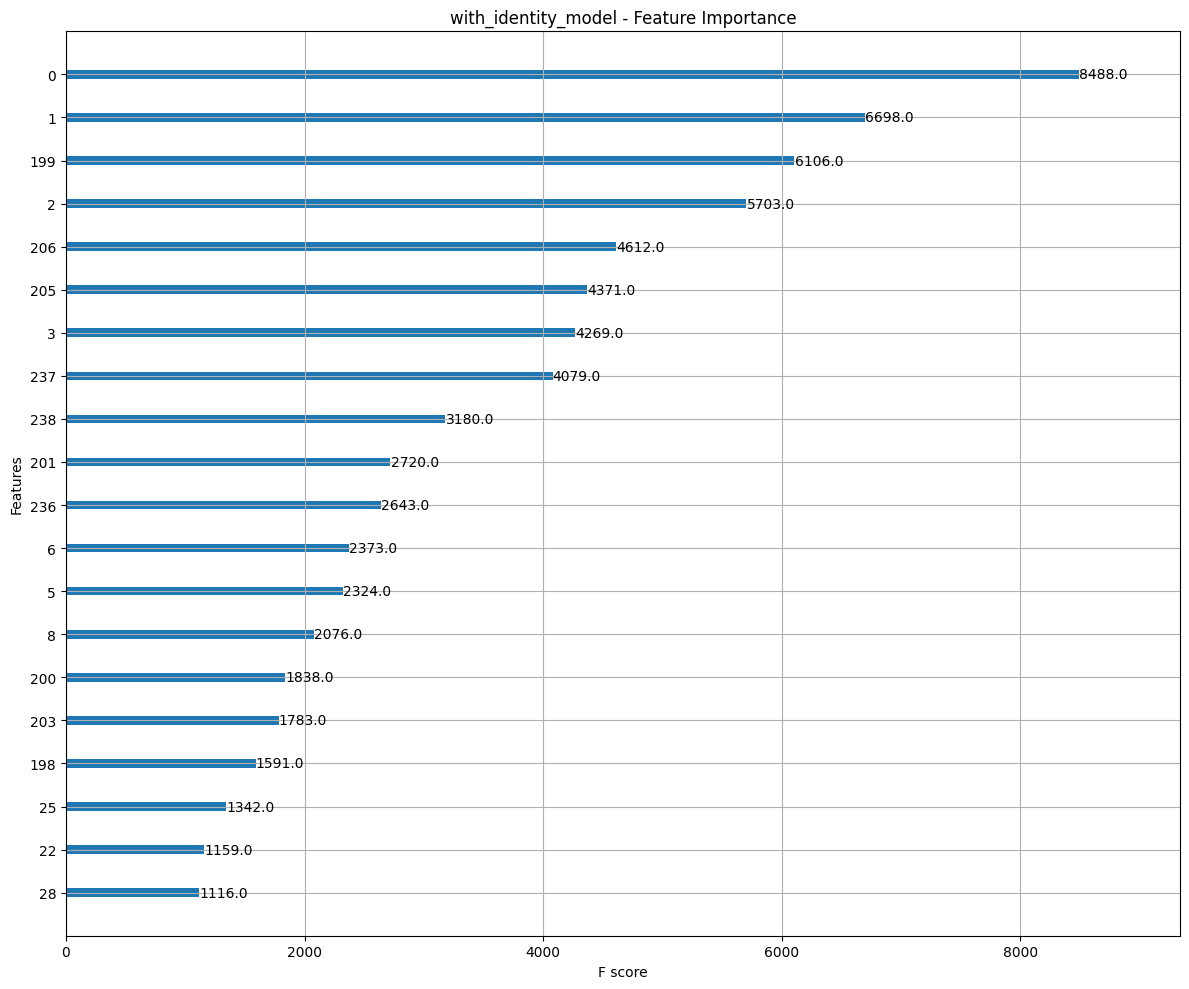

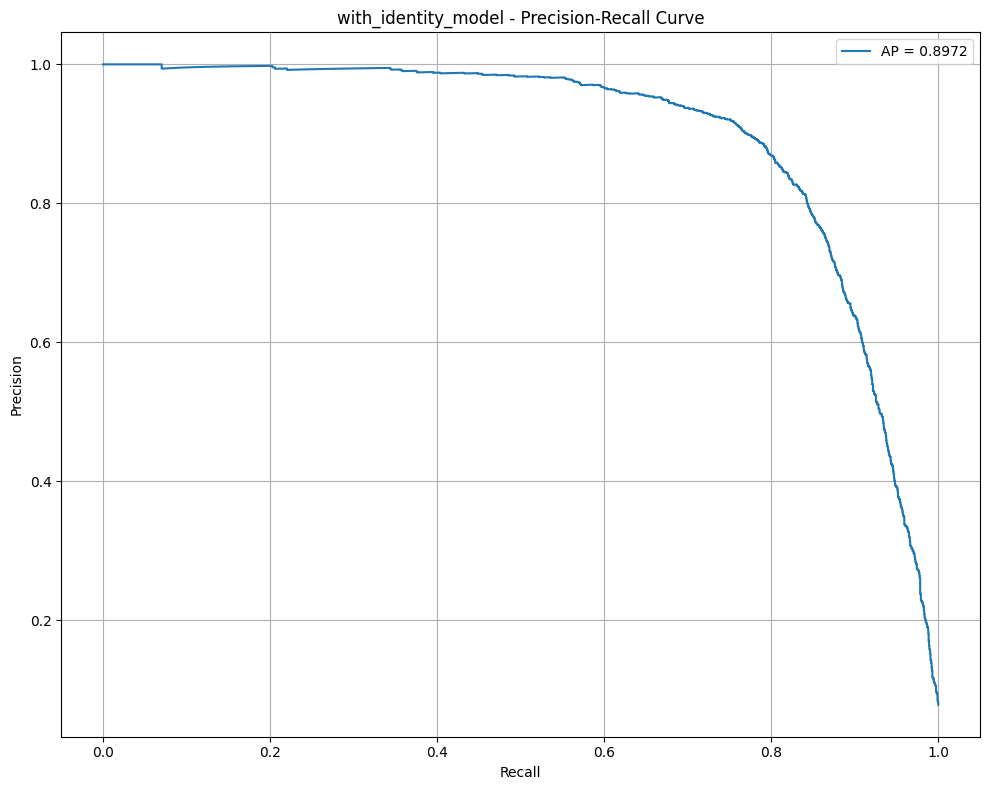

In [64]:
# Train model for WITH identity data
with_identity_model, with_identity_preds, with_identity_auc, with_identity_ap = train_and_evaluate_xgb(
    X_with_identity_train_processed, y_with_identity_train,
    X_with_identity_val_processed, y_with_identity_val,
    xgb_params.copy(), "with_identity_model"
)


Training without_identity_model model...
Class imbalance ratio (negative/positive): 46.76
Using scale_pos_weight: 46.76
[0]	train-auc:0.79684	val-auc:0.78079
[100]	train-auc:0.90518	val-auc:0.87451
[200]	train-auc:0.93723	val-auc:0.89806
[300]	train-auc:0.95352	val-auc:0.91012
[400]	train-auc:0.96598	val-auc:0.91879
[500]	train-auc:0.97391	val-auc:0.92453
[600]	train-auc:0.97992	val-auc:0.92986
[700]	train-auc:0.98404	val-auc:0.93319
[800]	train-auc:0.98732	val-auc:0.93675
[900]	train-auc:0.98986	val-auc:0.93972
[1000]	train-auc:0.99182	val-auc:0.94173
[1100]	train-auc:0.99339	val-auc:0.94325
[1200]	train-auc:0.99467	val-auc:0.94481
[1300]	train-auc:0.99564	val-auc:0.94610
[1400]	train-auc:0.99652	val-auc:0.94724
[1500]	train-auc:0.99716	val-auc:0.94833
[1600]	train-auc:0.99770	val-auc:0.94897
[1700]	train-auc:0.99807	val-auc:0.94965
[1800]	train-auc:0.99839	val-auc:0.95005
[1900]	train-auc:0.99867	val-auc:0.95045
[2000]	train-auc:0.99891	val-auc:0.95108
[2100]	train-auc:0.99909	val-a

2025/04/24 10:02:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


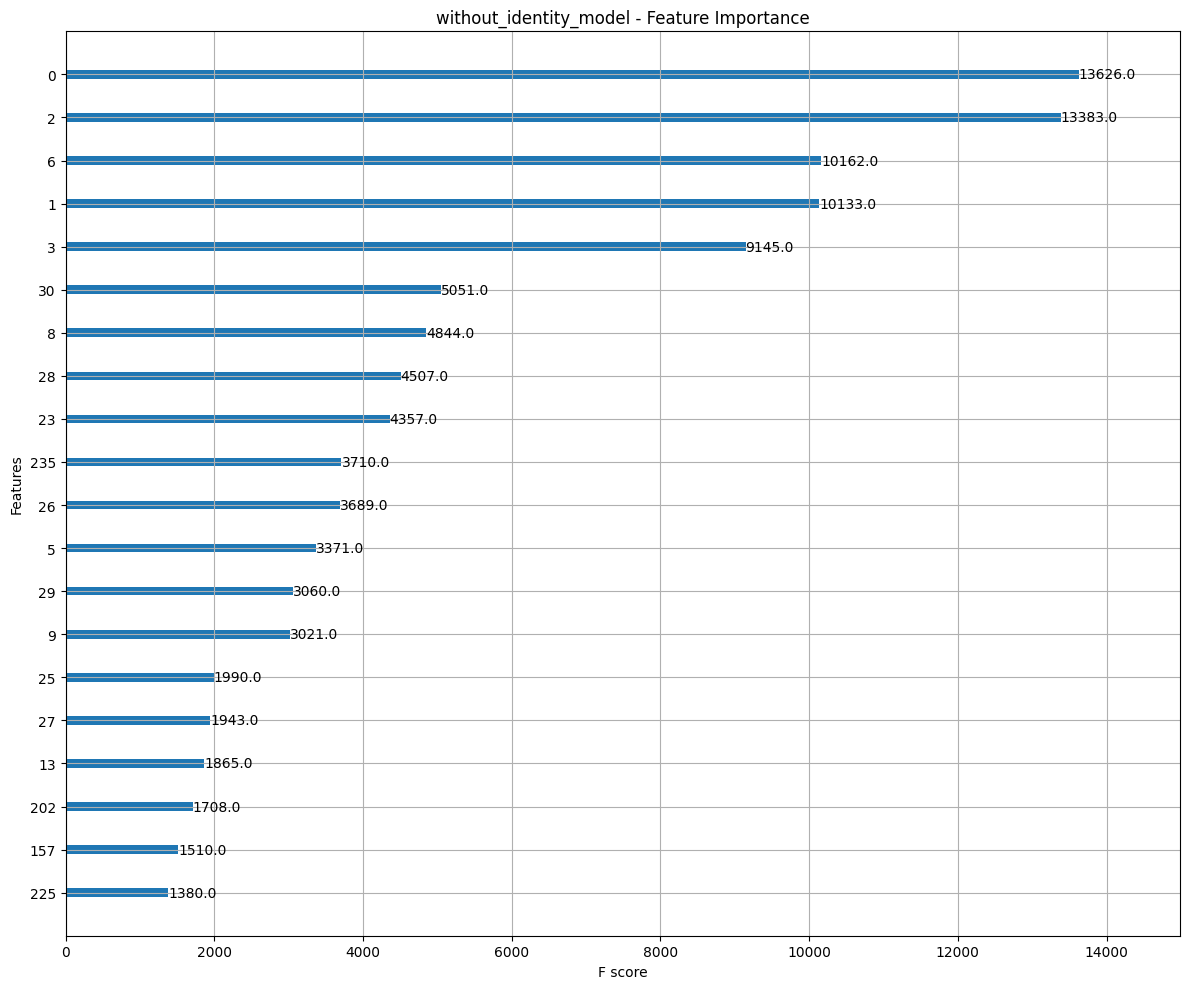

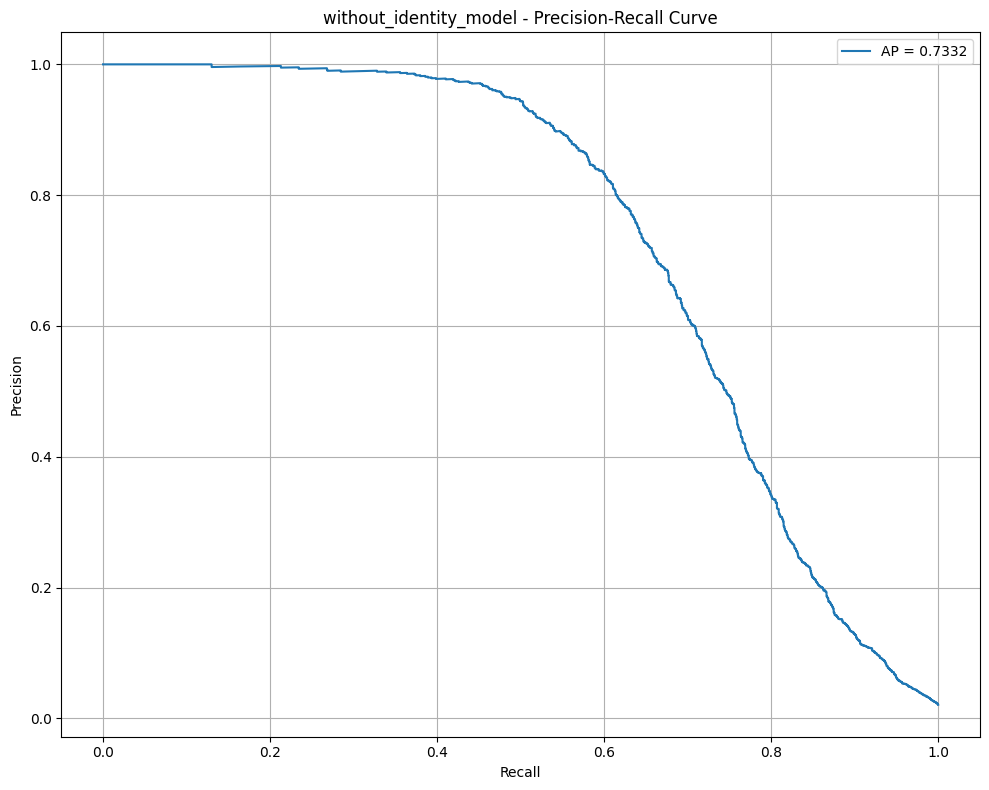

In [65]:
# Train model for WITHOUT identity data
without_identity_model, without_identity_preds, without_identity_auc, without_identity_ap = train_and_evaluate_xgb(
    X_without_identity_train_processed, y_without_identity_train,
    X_without_identity_val_processed, y_without_identity_val,
    xgb_params.copy(), "without_identity_model"
)

In [67]:
print("\n--- Individual Model Comparison ---")
print(f"WITH identity model - Validation AUC: {with_identity_auc:.4f}, AP: {with_identity_ap:.4f}")
print(f"WITHOUT identity model - Validation AUC: {without_identity_auc:.4f}, AP: {without_identity_ap:.4f}")

if with_identity_auc > without_identity_auc:
    print("The WITH identity model performs better in terms of AUC.")
else:
    print("The WITHOUT identity model performs better in terms of AUC.")

if with_identity_ap > without_identity_ap:
    print("The WITH identity model performs better in terms of Average Precision.")
else:
    print("The WITHOUT identity model performs better in terms of Average Precision.")



--- Individual Model Comparison ---
WITH identity model - Validation AUC: 0.9773, AP: 0.8972
WITHOUT identity model - Validation AUC: 0.9545, AP: 0.7332
The WITH identity model performs better in terms of AUC.
The WITH identity model performs better in terms of Average Precision.


### Step 11: Merge models and evaluate combined performance

In [68]:
# Create a combined validation set
combined_val_preds = []
combined_val_true = []

# Add predictions from WITH identity model
combined_val_preds.extend(with_identity_preds)
combined_val_true.extend(y_with_identity_val)

# Add predictions from WITHOUT identity model
combined_val_preds.extend(without_identity_preds)
combined_val_true.extend(y_without_identity_val)

# Convert to numpy arrays
combined_val_preds = np.array(combined_val_preds)
combined_val_true = np.array(combined_val_true)

# Calculate metrics for different thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
best_f1 = 0
best_threshold = 0.5

In [69]:
print("\nPerformance at different thresholds:")
print("Threshold | Precision | Recall | F1 Score | Accuracy")
print("----------|-----------|--------|----------|----------")

for threshold in thresholds:
    # Convert probabilities to binary predictions
    combined_val_pred_binary = (combined_val_preds >= threshold).astype(int)
    
    # Calculate metrics
    precision = precision_score(combined_val_true, combined_val_pred_binary)
    recall = recall_score(combined_val_true, combined_val_pred_binary)
    f1 = f1_score(combined_val_true, combined_val_pred_binary)
    accuracy = (combined_val_pred_binary == combined_val_true).mean()
    
    print(f"{threshold:.1f}       | {precision:.4f}    | {recall:.4f} | {f1:.4f}   | {accuracy:.4f}")
    
    # Track best F1 score
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Use the threshold with the best F1 score
print(f"\nBest threshold based on F1 score: {best_threshold:.2f}")
combined_val_pred_binary = (combined_val_preds >= best_threshold).astype(int)



Performance at different thresholds:
Threshold | Precision | Recall | F1 Score | Accuracy
----------|-----------|--------|----------|----------
0.1       | 0.2256    | 0.9214 | 0.3624   | 0.8866
0.2       | 0.3493    | 0.8836 | 0.5007   | 0.9383
0.3       | 0.4615    | 0.8568 | 0.5999   | 0.9600
0.4       | 0.5666    | 0.8248 | 0.6717   | 0.9718
0.5       | 0.6628    | 0.7951 | 0.7229   | 0.9787
0.6       | 0.7477    | 0.7658 | 0.7566   | 0.9828
0.7       | 0.8256    | 0.7251 | 0.7721   | 0.9850
0.8       | 0.8914    | 0.6789 | 0.7708   | 0.9859
0.9       | 0.9456    | 0.5974 | 0.7322   | 0.9847

Best threshold based on F1 score: 0.70


In [70]:
# Calculate comprehensive metrics
combined_precision = precision_score(combined_val_true, combined_val_pred_binary)
combined_recall = recall_score(combined_val_true, combined_val_pred_binary)
combined_f1 = f1_score(combined_val_true, combined_val_pred_binary)
combined_auc = roc_auc_score(combined_val_true, combined_val_preds)
combined_ap = average_precision_score(combined_val_true, combined_val_preds)

# Print comprehensive results
print("\n--- Combined Model Performance (at optimal threshold) ---")
print(f"Precision: {combined_precision:.4f}")
print(f"Recall: {combined_recall:.4f}")
print(f"F1 Score: {combined_f1:.4f}")
print(f"ROC AUC: {combined_auc:.4f}")
print(f"Average Precision: {combined_ap:.4f}")



--- Combined Model Performance (at optimal threshold) ---
Precision: 0.8256
Recall: 0.7251
F1 Score: 0.7721
ROC AUC: 0.9675
Average Precision: 0.8237


In [72]:
cm = confusion_matrix(combined_val_true, combined_val_pred_binary)
tn, fp, fn, tp = cm.ravel()

print("\nConfusion Matrix:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Calculate additional metrics
specificity = tn / (tn + fp)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0

print(f"\nSpecificity: {specificity:.4f}")
print(f"Negative Predictive Value: {npv:.4f}")



Confusion Matrix:
True Negatives: 113343
False Positives: 633
False Negatives: 1136
True Positives: 2997

Specificity: 0.9944
Negative Predictive Value: 0.9901


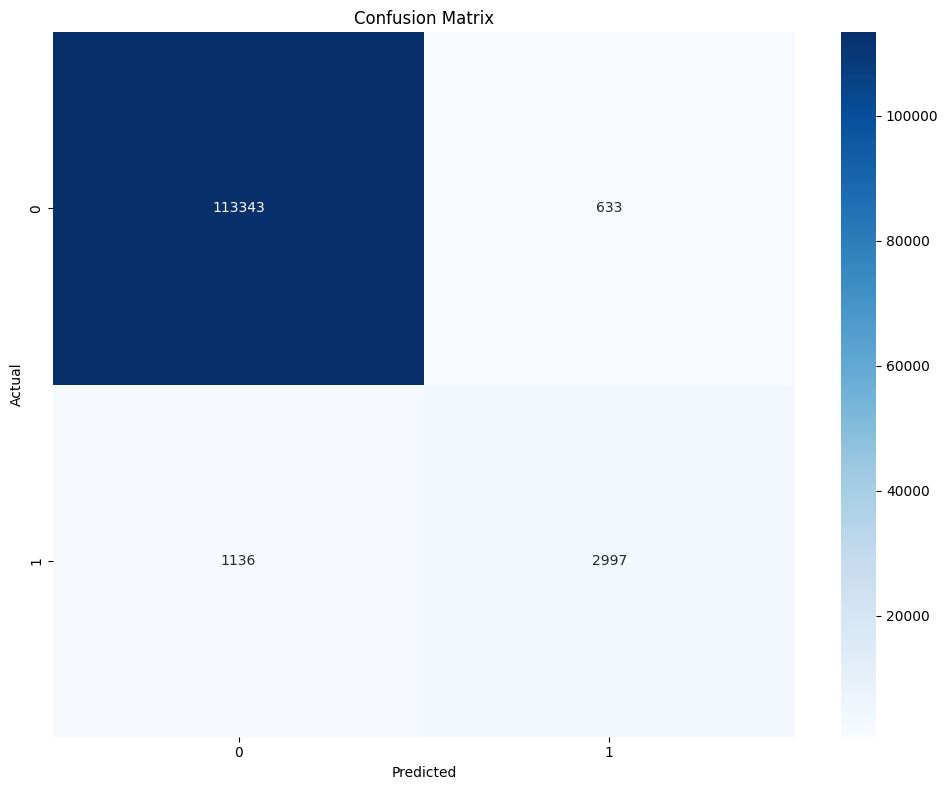

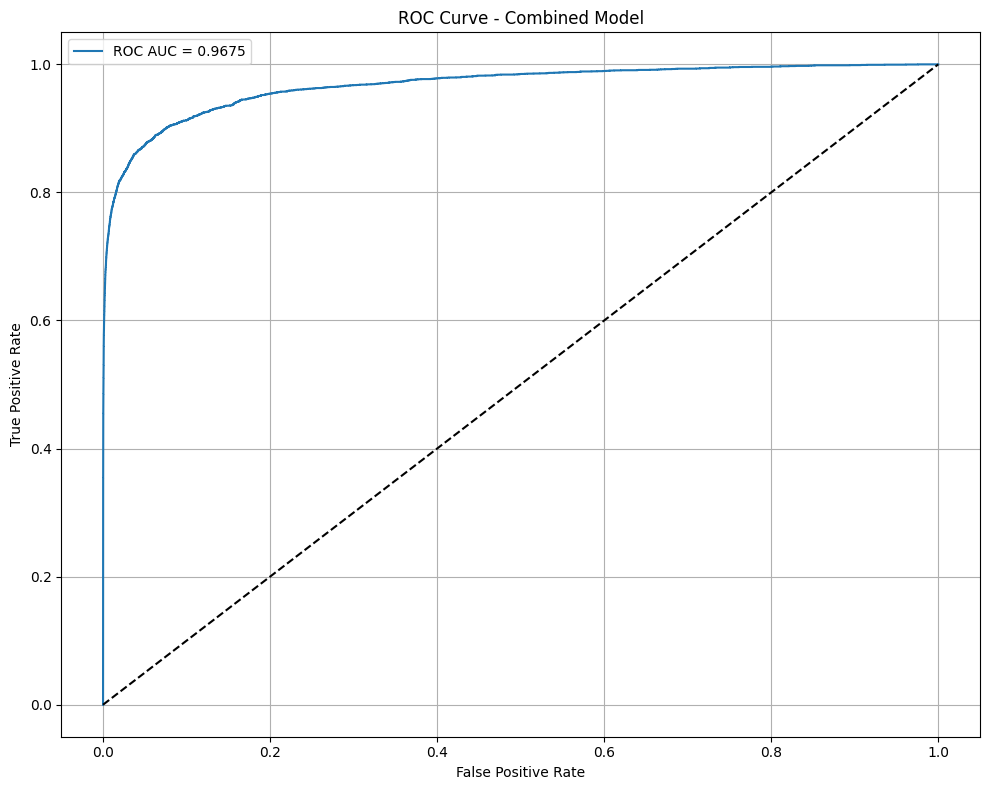

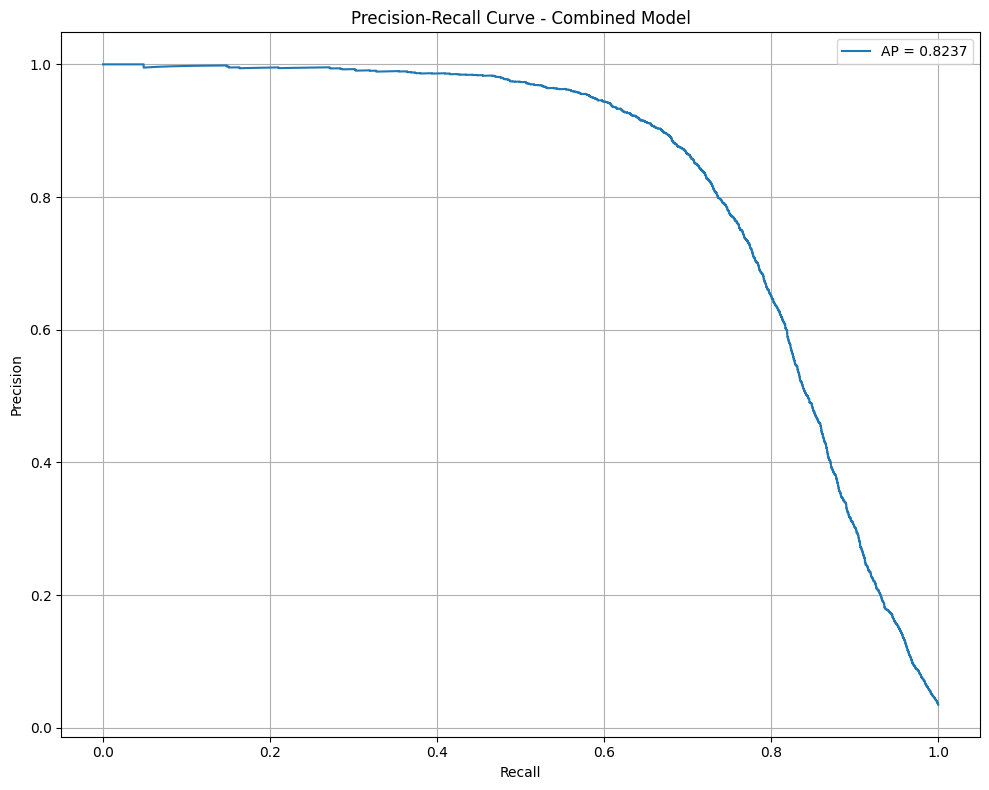

In [73]:
if mlflow_active:
    mlflow.log_metric("combined_precision", combined_precision)
    mlflow.log_metric("combined_recall", combined_recall)
    mlflow.log_metric("combined_f1", combined_f1)
    mlflow.log_metric("combined_auc", combined_auc)
    mlflow.log_metric("combined_ap", combined_ap)
    mlflow.log_metric("best_threshold", best_threshold)
    
    # Log confusion matrix
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')
    plt.tight_layout()
    cm_path = "combined_confusion_matrix.png"
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)
    
    # Log ROC curve
    fpr, tpr, _ = roc_curve(combined_val_true, combined_val_preds)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(fpr, tpr, label=f'ROC AUC = {combined_auc:.4f}')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve - Combined Model')
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    roc_path = "combined_roc_curve.png"
    plt.savefig(roc_path)
    mlflow.log_artifact(roc_path)
    
    # Log precision-recall curve
    precision, recall, _ = precision_recall_curve(combined_val_true, combined_val_preds)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(recall, precision, label=f'AP = {combined_ap:.4f}')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve - Combined Model')
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    pr_path = "combined_pr_curve.png"
    plt.savefig(pr_path)
    mlflow.log_artifact(pr_path)


In [75]:
print("\nClassification Report:")
print(classification_report(combined_val_true, combined_val_pred_binary))



Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    113976
           1       0.83      0.73      0.77      4133

    accuracy                           0.99    118109
   macro avg       0.91      0.86      0.88    118109
weighted avg       0.98      0.99      0.98    118109



# SHAP values

In [77]:
import shap

In [80]:
print("\n--- Calculating SHAP Values for Feature Importance ---")

# Create a small sample for SHAP values calculation (for efficiency)
if len(y_with_identity_val) > 1000:
    # Take a random sample of 1000 validation examples for SHAP calculation
    np.random.seed(42)
    sample_indices = np.random.choice(len(y_with_identity_val), 1000, replace=False)
    
    # Handle different data formats (DataFrame vs numpy array)
    if isinstance(X_with_identity_val_processed, pd.DataFrame):
        X_sample = X_with_identity_val_processed.iloc[sample_indices]
    else:
        X_sample = X_with_identity_val_processed[sample_indices, :]
else:
    # Use all validation examples if less than 1000
    X_sample = X_with_identity_val_processed

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(with_identity_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

# Create summary plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - WITH identity")
plt.tight_layout()
shap_importance_path = "shap_importance_with_identity.png"
plt.savefig(shap_importance_path)
plt.close()

# Create detailed SHAP summary plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("SHAP Summary Plot - WITH identity")
plt.tight_layout()
shap_summary_path = "shap_summary_with_identity.png"
plt.savefig(shap_summary_path)
plt.close()

# Create SHAP dependence plots for top features
# Get feature names or indices
if isinstance(X_sample, pd.DataFrame):
    feature_names = X_sample.columns.tolist()
else:
    # If not a DataFrame, create generic feature names
    feature_names = [f"feature_{i}" for i in range(X_sample.shape[1])]

# Get the mean absolute SHAP values for each feature
mean_abs_shap = np.abs(shap_values).mean(0)
# Get indices of top 5 features
top_indices = np.argsort(mean_abs_shap)[-5:]

# Create dependence plots for top 5 features
shap_dependence_paths = []
for i in top_indices:
    plt.figure(figsize=(10, 8))
    feature_name = feature_names[i] if i < len(feature_names) else f"feature_{i}"
    shap.dependence_plot(i, shap_values, X_sample, show=False)
    plt.title(f"SHAP Dependence Plot - {feature_name}")
    plt.tight_layout()
    
    # Convert feature_name to string and replace spaces with underscores
    safe_feature_name = str(feature_name).replace(' ', '_')
    dependence_path = f"shap_dependence_{safe_feature_name}.png"
    
    plt.savefig(dependence_path)
    plt.close()
    shap_dependence_paths.append(dependence_path)

# Log SHAP artifacts to MLflow if active
if mlflow_active:
    try:
        mlflow.log_artifact(shap_importance_path)
        mlflow.log_artifact(shap_summary_path)
        for path in shap_dependence_paths:
            mlflow.log_artifact(path)
        print("SHAP visualizations logged to MLflow")
    except Exception as e:
        print(f"Warning: Error logging SHAP visualizations to MLflow: {e}")

print("\n--- SHAP Analysis Complete ---")



--- Calculating SHAP Values for Feature Importance ---
SHAP visualizations logged to MLflow

--- SHAP Analysis Complete ---


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

# Finish model

In [82]:
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

if mlflow_active:
    mlflow.log_metric("total_execution_time", execution_time)
    mlflow.end_run()
    print("MLflow run completed successfully.")

print("\n=== XGBoost Fraud Detection Pipeline Complete ===") 


Total execution time: 2914.65 seconds
🏃 View run fortunate-bug-991 at: https://dagshub.com/konstantine25b/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/12/runs/cd27fef9a2a04b8d8b9f66d8d6ede169
🧪 View experiment at: https://dagshub.com/konstantine25b/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/12
MLflow run completed successfully.

=== XGBoost Fraud Detection Pipeline Complete ===
